# Импорт библиотек

In [98]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import silhouette_score,silhouette_samples,adjusted_rand_score,davies_bouldin_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,DBSCAN,MiniBatchKMeans,MeanShift,SpectralClustering,AgglomerativeClustering,AffinityPropagation
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import TSNE


import random
import vk
import time
import datetime
import dateutil

# Данные для VK API

In [99]:
access_token_base = '5fc6b85cae91f2ace8ba843da29d0db6c81b798cb4a71733dc6973e0611a5e1e4a69381d5ee386ca5e577'


version = 5.126

# Парсинг данных

In [100]:
%%time
session = vk.Session(access_token = access_token_base)
vk_api = vk.API(session)
friends = vk_api.friends.get(v = version)

friends_ids_list = friends['items']
fields_name = ['first_name','last_name','id','sex','bdate',
               'country','home_town',
               'has_mobile','followers_count','schools',
               'common_count','universities']


dict_users_requests = {}
results = []

for friend in friends_ids_list:
    dict_results = {}
    dict_users_requests = {}
    for column in fields_name:
        try:
            dict_result = {column : vk_api.users.get(user_ids = friend, v = version,fields = fields_name)[0][column]}
            
        except:
            dict_result = {column: np.nan}
        
        finally:
            dict_users_requests.update(dict_result)
        time.sleep(1)
    results.append(dict_users_requests)
    
        

Wall time: 51min


In [101]:
df = pd.DataFrame(results)
df

,first_name,last_name,id,sex,bdate,country,home_town,has_mobile,followers_count,schools,common_count,universities
0,Дмитрий,Косарев,1092857,2,16.1.1991,"{'id': 1, 'title': 'Россия'}",Москва,1.0,60.0,"[{'city': 1, 'class': 'а', 'country': 1, 'id':...",15.0,"[{'chair': 1046, 'chair_name': 'Менеджмента и ..."
1,Христиан,Сенчугов,1585818,2,26.6,"{'id': 1, 'title': 'Россия'}",NaN,1.0,1251.0,NaN,26.0,NaN
2,Таня,Цветкова,2720840,1,6.1.1993,"{'id': 1, 'title': 'Россия'}",Москва,1.0,215.0,"[{'city': 1, 'class': 'б', 'country': 1, 'id':...",28.0,"[{'city': 1, 'country': 1, 'education_form': '..."
3,Mishwa,T-B,4108471,2,7.2,"{'id': 1, 'title': 'Россия'}",,1.0,51.0,"[{'city': 1965294, 'class': '', 'country': 7, ...",2.0,[]
4,Стас,Шатило,4298034,2,NaN,"{'id': 1, 'title': 'Россия'}",NaN,1.0,164.0,NaN,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
235,Алексей,Матвеев,497967635,2,10.1,"{'id': 1, 'title': 'Россия'}",NaN,1.0,30.0,NaN,17.0,NaN
236,Свят,Солнцев,521321572,2,7.2.1989,"{'id': 1, 'title': 'Россия'}",,1.0,59.0,[],1.0,[]
237,Виктор,Соболь,523330243,2,21.12.2003,"{'id': 1, 'title': 'Россия'}",Москва,1.0,18.0,[],15.0,[]
238,Слива,Стак,527217026,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Обработка полученных данных

In [102]:
#1 
for el in df:
    for i in range(len(df[el])):
        if type(df[el][i]) == dict:
            for key in df[el][i]:
                column = str(el)+ '_' + str(key)
                
                if column not in df:
                    df[column] = ['']*len(df)
                    
                df[column][i] = df[el][i][key]
        
        
        
        if type(df[el][i]) == list:
            if len(df[el][i]) == 0:
                df[el][i] = np.nan
            else:
                
                
                for key in df[el][i][-1]:
                    column = str(el)+ '_last_' + str(key)
                    if column not in df:
                        df[column] = ['']*len(df)
                    df[column][i] = df[el][i][-1][key]
                    
        else:
            pass
                     
  

In [103]:
def date_2_age(df_func,column,new_column):
    
    days = []
    months = []
    years = []
    for_new_list = []
    today =  datetime.datetime.utcnow()
    for elem in df_func[column]:
        if type(elem) == str:
                         
            date_list = elem.split('.')
            if len(date_list) < 3:
                days.append(np.nan)
                months.append(np.nan)
                years.append(np.nan)
            else:    
                days.append(date_list[0])
                months.append(date_list[1])
                years.append(date_list[2])
        if type(elem) == float:
            days.append(np.nan)
            months.append(np.nan)
            years.append(np.nan)
    for i in range(len(days)):
        if type(days[i]) == str:
            for_new_list.append(dateutil.relativedelta.relativedelta(today,datetime.date(int(years[i]),
                                                                                         int(months[i]),
                                                                                         int(days[i]))).years)
        else:
            for_new_list.append(np.nan)
    
            
    df_func[new_column] = for_new_list
    return df_func
df = date_2_age(df_func = df,column = 'bdate', new_column = 'Age')

In [104]:
# Сохранение данных
df.to_csv('sample_vk.csv')

In [105]:
# чтение данных 
sample = pd.read_csv('sample_vk.csv')
sample = sample.drop(['Unnamed: 0','country','schools'],axis = 1)

In [106]:
sample.head(20)

,first_name,last_name,id,sex,bdate,home_town,has_mobile,followers_count,common_count,universities,...,universities_last_city,universities_last_country,universities_last_education_form,universities_last_education_status,universities_last_faculty,universities_last_faculty_name,universities_last_graduation,universities_last_id,universities_last_name,Age
0,Дмитрий,Косарев,1092857,2,16.1.1991,Москва,1.0,60.0,15.0,"[{'chair': 1046, 'chair_name': 'Менеджмента и ...",...,1.0,1.0,Очное отделение,Выпускник (бакалавр),941.0,Факультет международного бизнеса и делового ад...,2011.0,236.0,МГИМО (У) МИД России,29.0
1,Христиан,Сенчугов,1585818,2,26.6,NaN,1.0,1251.0,26.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Таня,Цветкова,2720840,1,6.1.1993,Москва,1.0,215.0,28.0,"[{'city': 1, 'country': 1, 'education_form': '...",...,1.0,1.0,Очное отделение,NaN,33104.0,Социологический факультет,NaN,328.0,РГГУ,27.0
3,Mishwa,T-B,4108471,2,7.2,NaN,1.0,51.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Стас,Шатило,4298034,2,NaN,NaN,1.0,164.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Максим,Блажко,4381071,2,NaN,NaN,1.0,43.0,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Наталья,Синицина,4939369,1,27.6.1992,Москва,1.0,278.0,30.0,"[{'city': 1, 'country': 1, 'id': 289, 'name': ...",...,1.0,1.0,NaN,NaN,2265378.0,Кафедра хорового дирижирования,NaN,237.0,МГИМ им. А. Г. Шнитке,28.0
7,Вася,Поспелов,5304552,2,NaN,NaN,1.0,162.0,11.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Евгений,Бойтик,6509123,2,27.10,NaN,1.0,223.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Анна,Бурмистрова,6688521,1,17.4,Москва,1.0,208.0,1.0,"[{'city': 0, 'country': 0, 'education_form': '...",...,0.0,0.0,Очное отделение,Студентка (бакалавр),514.0,Институт экономики и финансов,2016.0,131.0,ГУУ,NaN


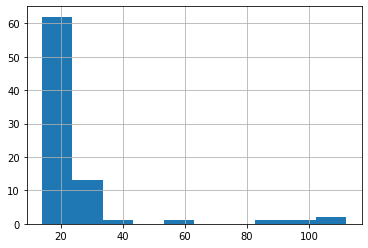

In [107]:
sample['Age'].hist()

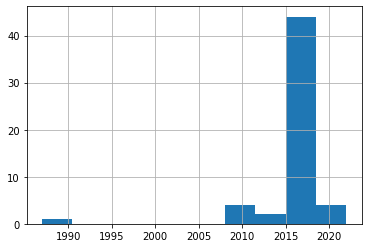

In [108]:
sample['schools_last_year_graduated'].hist()

In [109]:
for column in sample:
    print(f'В столбце {column} пропусков {sample[column].isna().sum()}')
    print(f'Что составляет {100*round(sample[column].isna().sum()/len(sample[column]),4)} % от общего количества значений по столбцу')
    print('------------------------------------------------------------------------------------------------')
    

В столбце first_name пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце last_name пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце id пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце sex пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце bdate пропусков 32
Что составляет 13.33 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце home_town пропусков 123
Что составляет 51.249999

In [110]:
sample.describe()

,id,sex,has_mobile,followers_count,common_count,country_id,schools_last_city,schools_last_country,schools_last_id,schools_last_year_from,schools_last_year_graduated,schools_last_year_to,schools_last_type,universities_last_chair,universities_last_city,universities_last_country,universities_last_faculty,universities_last_graduation,universities_last_id,Age
count,2.400000e+02,240.000000,239.000000,206.000000,239.000000,209.000000,9.500000e+01,95.000000,9.500000e+01,51.000000,55.000000,52.000000,25.000000,3.300000e+01,1.110000e+02,111.000000,6.900000e+01,32.000000,111.000000,81.000000
mean,1.633227e+08,1.587500,0.983264,211.703883,23.276151,4.736842,5.248457e+04,2.052632,1.191477e+05,2005.921569,2015.981818,2015.230769,3.920000,1.403791e+06,1.427910e+05,6.954955,6.245017e+05,2017.281250,22739.603604,25.827160
std,1.113757e+08,0.493313,0.128551,226.447527,16.472765,22.261614,2.990126e+05,9.657285,3.318906e+05,12.125746,4.755079,5.241671,3.426855,9.053674e+05,6.848084e+05,30.306431,9.703858e+05,12.667546,119699.663014,18.378513
min,1.092857e+06,1.000000,0.000000,5.000000,0.000000,1.000000,1.000000e+00,1.000000,5.000000e+01,1935.000000,1987.000000,1987.000000,1.000000,2.840000e+02,0.000000e+00,0.000000,2.100000e+01,1953.000000,2.000000,14.000000
25%,8.662638e+07,1.000000,1.000000,89.000000,12.000000,1.000000,1.000000e+00,1.000000,4.293000e+03,2004.000000,2015.500000,2015.000000,2.000000,1.489100e+04,1.000000e+00,1.000000,5.140000e+02,2018.750000,133.500000,20.000000
50%,1.483597e+08,2.000000,1.000000,148.500000,21.000000,1.000000,1.000000e+00,1.000000,4.809000e+03,2006.000000,2017.000000,2017.000000,2.000000,1.929193e+06,1.000000e+00,1.000000,2.007000e+03,2020.000000,319.000000,21.000000
75%,2.221839e+08,2.000000,1.000000,269.000000,32.000000,1.000000,1.000000e+00,1.000000,4.857900e+04,2011.500000,2018.000000,2018.000000,7.000000,2.044711e+06,1.000000e+00,1.000000,1.928113e+06,2022.000000,348.000000,23.000000
max,5.596191e+08,2.000000,1.000000,1697.000000,115.000000,209.000000,1.965294e+06,95.000000,1.771664e+06,2018.000000,2022.000000,2022.000000,12.000000,2.183034e+06,5.261784e+06,209.000000,2.271124e+06,2025.000000,950610.000000,112.000000


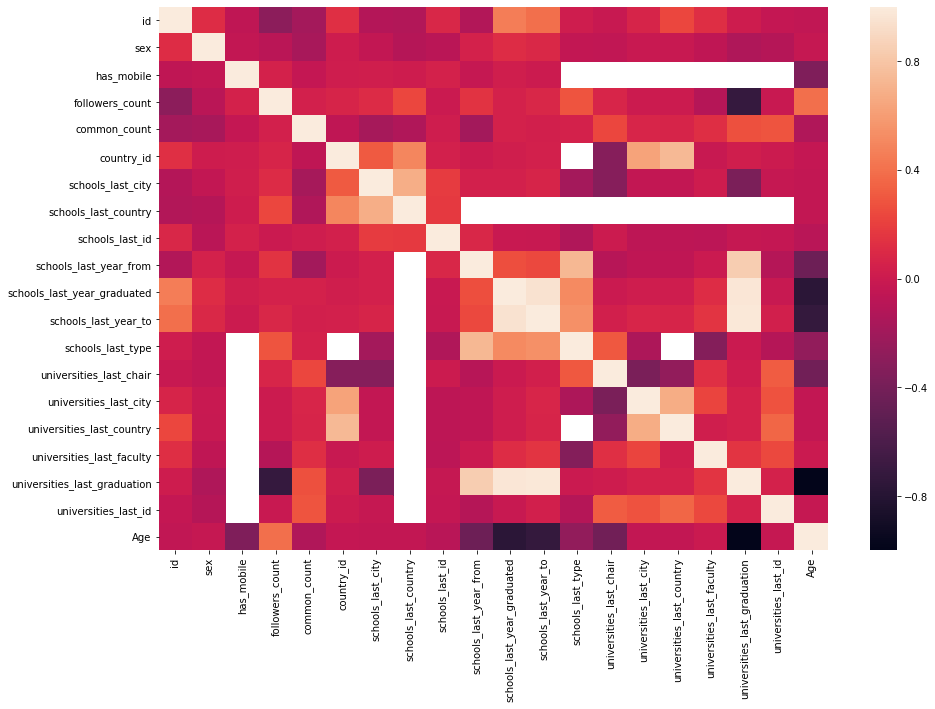

In [111]:
sns.heatmap(sample.corr())
fig = plt.gcf()
fig.set_size_inches(15,10)

Wall time: 47.3 s


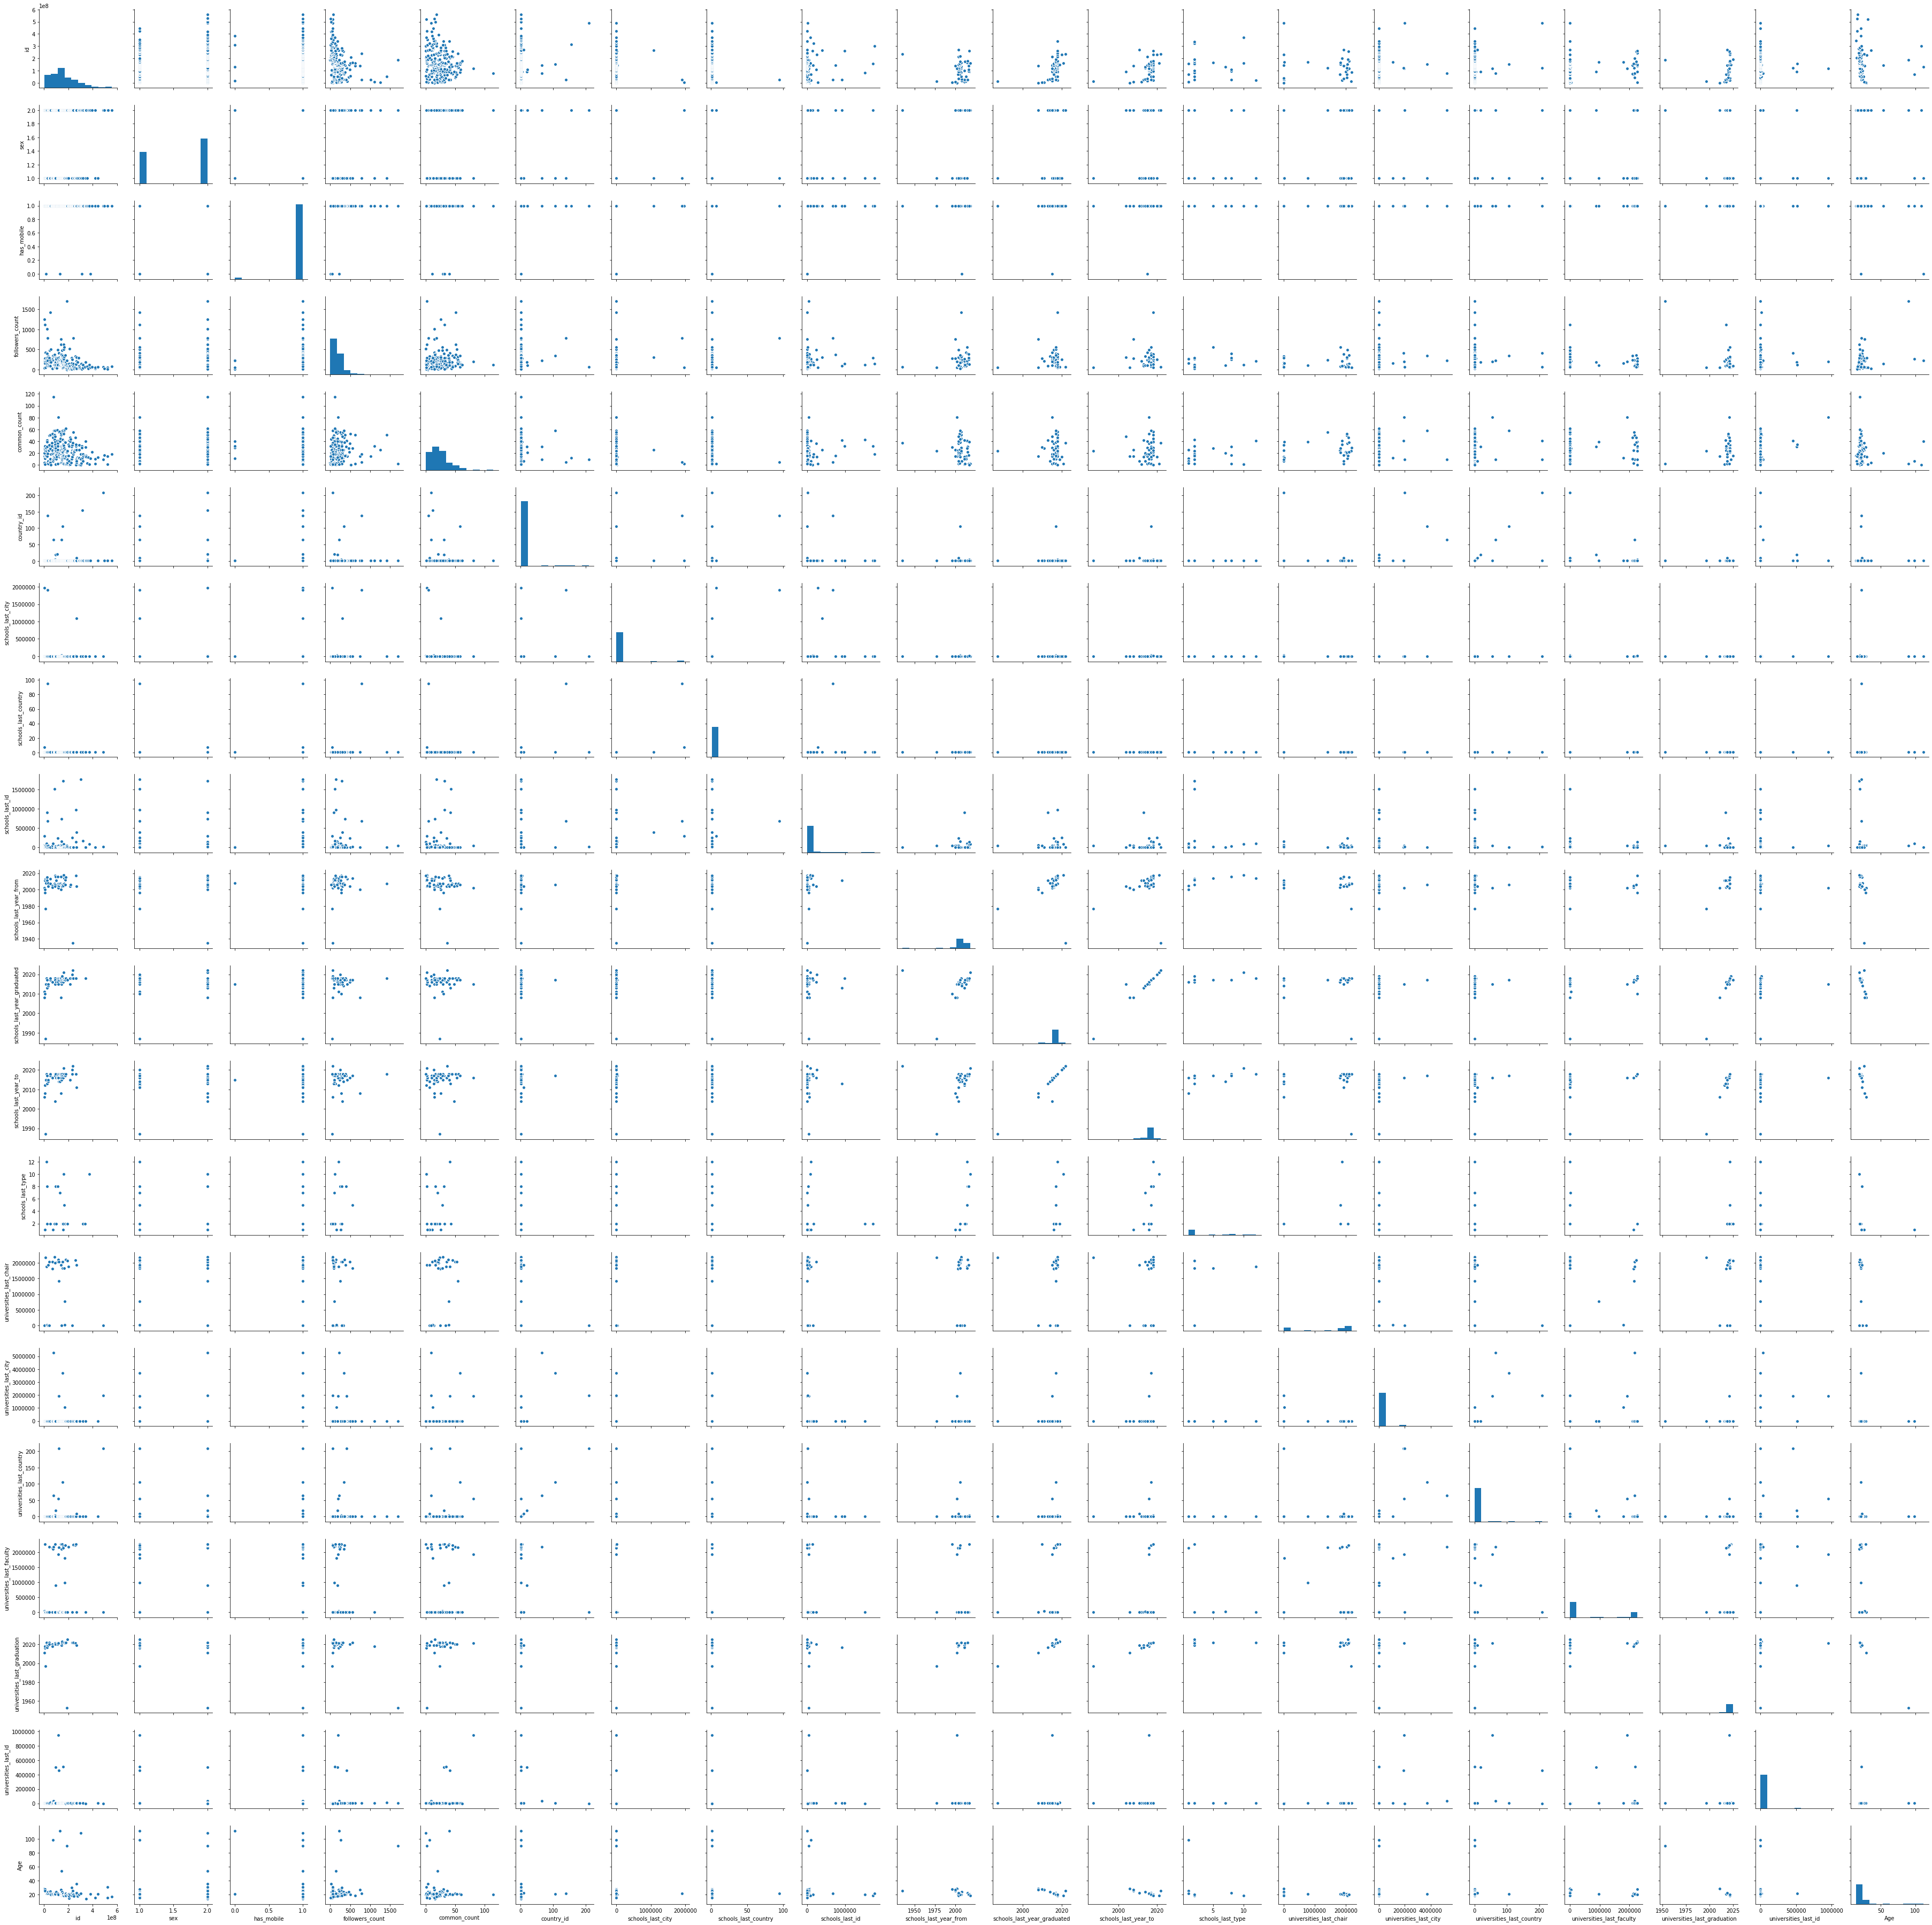

In [112]:
%%time
sns.pairplot(sample)

In [113]:
sample = sample.drop(['schools_last_type','schools_last_class','schools_last_year_from',
                      'schools_last_type_str','schools_last_speciality','universities_last_chair','universities_last_chair_name',
                      'universities_last_education_status','universities_last_education_form',
                      'schools_last_year_to','universities'
                      
                      
                     ],axis = 1)

In [114]:
df_plus = pd.read_csv('sample_vk_asya.csv')
df_plus = df_plus.drop(['Unnamed: 0','country','schools'],axis = 1)

df_plus = df_plus.drop(['schools_last_type','schools_last_class','schools_last_year_from',
                      'schools_last_type_str','schools_last_speciality','universities_last_chair','universities_last_chair_name',
                      'universities_last_education_status','universities_last_education_form',
                      'schools_last_year_to','universities'
                      
                      
                     ],axis = 1)

In [115]:
df_sample1 = sample.append(df_plus) 

In [116]:
df_sample1 = df_sample1.drop_duplicates(subset=['first_name','last_name'], keep='first', inplace=False, ignore_index=False)
df_sample1 = df_sample1.dropna(axis = 0, subset = ['last_name']) # Очистка удаленных пользователей
df_sample1.head(60)

,first_name,last_name,id,sex,bdate,home_town,has_mobile,followers_count,common_count,country_id,...,schools_last_name,schools_last_year_graduated,universities_last_city,universities_last_country,universities_last_faculty,universities_last_faculty_name,universities_last_graduation,universities_last_id,universities_last_name,Age
0,Дмитрий,Косарев,1092857,2,16.1.1991,Москва,1.0,60.0,15.0,1.0,...,Центр образования № 1953 «Москва-98»,2008.0,1.0,1.0,941.0,Факультет международного бизнеса и делового ад...,2011.0,236.0,МГИМО (У) МИД России,29.0
1,Христиан,Сенчугов,1585818,2,26.6,NaN,1.0,1251.0,26.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Таня,Цветкова,2720840,1,6.1.1993,Москва,1.0,215.0,28.0,1.0,...,Школа № 2123 им. Мигеля Эрнандеса (шк. 110),2011.0,1.0,1.0,33104.0,Социологический факультет,NaN,328.0,РГГУ,27.0
3,Mishwa,T-B,4108471,2,7.2,NaN,1.0,51.0,2.0,1.0,...,Школа № 18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Стас,Шатило,4298034,2,NaN,NaN,1.0,164.0,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Максим,Блажко,4381071,2,NaN,NaN,1.0,43.0,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Наталья,Синицина,4939369,1,27.6.1992,Москва,1.0,278.0,30.0,1.0,...,Хоровая студия «Веснянка»,2010.0,1.0,1.0,2265378.0,Кафедра хорового дирижирования,NaN,237.0,МГИМ им. А. Г. Шнитке,28.0
7,Вася,Поспелов,5304552,2,NaN,NaN,1.0,162.0,11.0,NaN,...,Гимназия №1567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Евгений,Бойтик,6509123,2,27.10,NaN,1.0,223.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Анна,Бурмистрова,6688521,1,17.4,Москва,1.0,208.0,1.0,NaN,...,Школа № 3,NaN,0.0,0.0,514.0,Институт экономики и финансов,2016.0,131.0,ГУУ,NaN


In [117]:
for column in df_sample1:
    print(f'В столбце {column} пропусков {df_sample1[column].isna().sum()}')
    print(f'Что составляет {100*round(df_sample1[column].isna().sum()/len(df_sample1[column]),4)} % от общего количества значений по столбцу')
    print('------------------------------------------------------------------------------------------------')
    

В столбце first_name пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце last_name пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце id пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце sex пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце bdate пропусков 109
Что составляет 16.98 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце home_town пропусков 312
Что составляет 48.6 % о

In [118]:
df_sample1['home_town'].unique()

array(['Москва', nan, 'Самара, Москва', 'Moscow', 'MASKAU',
       'Нижневартовск', 'Атомск', 'Уфа', 'москва', 'Mосква', 'Дзержинск',
       'Старый Оскол', 'Пекин', 'Волгоград-Дубовка', 'Берлин',
       'Moscow-city', 'Пенза', 'Санкт-Петербург', 'Омск', 'Новый Уренгой',
       'Кимры', 'Москва, Сочи', 'New York', 'moscow', 'Волгоград',
       'Владимир', 'домодедово', 'Москвабад', 'Воронеж', 'MOSCOW CITY',
       'Казань', 'Электросталь', 'Комсомольск-на-Амуре', 'Конченбург',
       'Ярцево', 'Алматы', 'Якутск', 'Memphis', 'Barcelona', 'Moscou',
       'Владикавказ', 'Грозный', 'Москва, Париж', 'Пермь', 'Красноярск',
       'Химки', 'Иваново, Москва', 'Шымкент', 'Смоленск', 'Запрудня',
       'Буэнос-Айрес', 'Россия', 'Вологда', 'Ковров', 'Тула', 'Киев',
       'Дыдылдино', 'Ноябрьск', 'Нижний Новгород', 'Сибирь', 'Московушка',
       'Одинцово', 'Луховицы', 'Москва.', 'Никель, Вологда', 'Самара',
       'Элиста', 'Волжский', 'Харьков',
       'Губкинский, Муравленко, Салехард', 'Минс

In [119]:
for column in df_sample1:
    print(f'В столбце {column} пропусков {df_sample1[column].isna().sum()}')
    print(f'Что составляет {100*round(df_sample1[column].isna().sum()/len(df_sample1[column]),4)} % от общего количества значений по столбцу')
    print('------------------------------------------------------------------------------------------------')
        

В столбце first_name пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце last_name пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце id пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце sex пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце bdate пропусков 109
Что составляет 16.98 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце home_town пропусков 312
Что составляет 48.6 % о

In [120]:
# Проверка можно ли заполнить данные по возрасту относительно других данных связанных с годами
for i in range(len(df_sample1['Age'])):
    today_year =  datetime.datetime.utcnow().year
    try:
        if np.isnan(df_sample1['Age'][i]) == True:
            if np.isnan(df_sample1['schools_last_year_graduated'][i]) == False:
                df_sample1.iloc[i]['Age'] = (today_year - df_sample1['schools_last_year_graduated'][i] - random.randint(17,18))
            else:
                if np.isnan(df_sample1['universities_last_graduation'][i]) == False:
                    df_sample1.iloc1[i]['Age'] = (today_year - df_sample1['universities_last_graduation'][i] - random.randint(21,23)) 
                else:
                    pass
        else:
            pass
    except:
        pass
 

In [121]:
# Проверка можно ли заполнить данные год окончания школы относительно других данных связанных с годами
for i in range(len(df_sample1['schools_last_year_graduated'])):
    today_year =  datetime.datetime.utcnow().year
    try:
        if np.isnan(df_sample1['schools_last_year_graduated'][i]) == True:
            if np.isnan(df_sample1['Age'][i]) == False:
                df_sample1.iloc[i]['schools_last_year_graduated'] = (today_year - df_sample1['Age'][i] + random.randint(17,18))
            else:
                if np.isnan(df_sample1['universities_last_graduation'][i]) == False:
                    df_sample1.iloc1[i]['schools_last_year_graduated'] = (df_sample1['universities_last_graduation'][i] - random.randint(4,6)) 
                else:
                    pass
        else:
            pass
    except:
        pass
 

In [122]:
# Проверка можно ли заполнить данные год окончания университета относительно других данных связанных с годами
for i in range(len(df_sample1['universities_last_graduation'])):
    today_year =  datetime.datetime.utcnow().year
    try:
        if np.isnan(df_sample1['universities_last_graduation'][i]) == True:
            if np.isnan(df_sample1['Age'][i]) == False:
                df_sample1.iloc[i]['universities_last_graduation'] = (today_year - df_sample1['Age'][i] + random.randint(21,25))
            else:
                if np.isnan(df_sample1['schools_last_year_graduated'][i]) == False:
                    df_sample1.iloc1[i]['universities_last_graduation'] = (df_sample1['schools_last_year_graduated'][i] + random.randint(4,6)) 
                else:
                    pass
        else:
            pass
    except:
        pass
 

In [123]:
for column in df_sample1:
    print(f'В столбце {column} пропусков {df_sample1[column].isna().sum()}')
    print(f'Что составляет {100*round(df_sample1[column].isna().sum()/len(df_sample1[column]),4)} % от общего количества значений по столбцу')
    print('------------------------------------------------------------------------------------------------')
    

В столбце first_name пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце last_name пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце id пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце sex пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце bdate пропусков 109
Что составляет 16.98 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце home_town пропусков 312
Что составляет 48.6 % о

In [124]:
for i in range(len(df_sample1['universities_last_graduation'])):
    try:
        if df_sample1['Age'][i] < 17:
            df_sampe1['universities_last_graduation'][i] = 'Не учится'
            df_sampe1['universities_last_name'][i] = 'Не учится'
            df_sampe1['universities_last_id'][i] = 'Не учится'
            df_sampe1['universities_last_faculty_name'][i] = 'Не учится'
            df_sample1['universities_last_faculty'][i] = 'Не учится'
            df_sampe1['universities_last_country'][i] = 'Не учится'
            df_sampe1['universities_last_city'][i] = 'Не учится'
            
        else:
            pass
        
    except:
        pass
        
    

In [125]:
df_sample2 = df_sample1.copy()
df_sample2 = df_sample2.interpolate()

In [126]:
df_sample2.columns

Index(['first_name', 'last_name', 'id', 'sex', 'bdate', 'home_town',
       'has_mobile', 'followers_count', 'common_count', 'country_id',
       'country_title', 'schools_last_city', 'schools_last_country',
       'schools_last_id', 'schools_last_name', 'schools_last_year_graduated',
       'universities_last_city', 'universities_last_country',
       'universities_last_faculty', 'universities_last_faculty_name',
       'universities_last_graduation', 'universities_last_id',
       'universities_last_name', 'Age'],
      dtype='object')

In [127]:
for column in df_sample2:
    print(f'В столбце {column} пропусков {df_sample2[column].isna().sum()}')
    print(f'Что составляет {100*round(df_sample2[column].isna().sum()/len(df_sample2[column]),4)} % от общего количества значений по столбцу')
    print('------------------------------------------------------------------------------------------------')
    

В столбце first_name пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце last_name пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце id пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце sex пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце bdate пропусков 109
Что составляет 16.98 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце home_town пропусков 312
Что составляет 48.6 % о

In [128]:
df_sample2['home_town'].unique()

array(['Москва', nan, 'Самара, Москва', 'Moscow', 'MASKAU',
       'Нижневартовск', 'Атомск', 'Уфа', 'москва', 'Mосква', 'Дзержинск',
       'Старый Оскол', 'Пекин', 'Волгоград-Дубовка', 'Берлин',
       'Moscow-city', 'Пенза', 'Санкт-Петербург', 'Омск', 'Новый Уренгой',
       'Кимры', 'Москва, Сочи', 'New York', 'moscow', 'Волгоград',
       'Владимир', 'домодедово', 'Москвабад', 'Воронеж', 'MOSCOW CITY',
       'Казань', 'Электросталь', 'Комсомольск-на-Амуре', 'Конченбург',
       'Ярцево', 'Алматы', 'Якутск', 'Memphis', 'Barcelona', 'Moscou',
       'Владикавказ', 'Грозный', 'Москва, Париж', 'Пермь', 'Красноярск',
       'Химки', 'Иваново, Москва', 'Шымкент', 'Смоленск', 'Запрудня',
       'Буэнос-Айрес', 'Россия', 'Вологда', 'Ковров', 'Тула', 'Киев',
       'Дыдылдино', 'Ноябрьск', 'Нижний Новгород', 'Сибирь', 'Московушка',
       'Одинцово', 'Луховицы', 'Москва.', 'Никель, Вологда', 'Самара',
       'Элиста', 'Волжский', 'Харьков',
       'Губкинский, Муравленко, Салехард', 'Минс

In [129]:
df_sample2.columns


Index(['first_name', 'last_name', 'id', 'sex', 'bdate', 'home_town',
       'has_mobile', 'followers_count', 'common_count', 'country_id',
       'country_title', 'schools_last_city', 'schools_last_country',
       'schools_last_id', 'schools_last_name', 'schools_last_year_graduated',
       'universities_last_city', 'universities_last_country',
       'universities_last_faculty', 'universities_last_faculty_name',
       'universities_last_graduation', 'universities_last_id',
       'universities_last_name', 'Age'],
      dtype='object')

In [130]:
df_sample2.dtypes

first_name                         object
last_name                          object
id                                  int64
sex                                 int64
bdate                              object
home_town                          object
has_mobile                        float64
followers_count                   float64
common_count                      float64
country_id                        float64
country_title                      object
schools_last_city                 float64
schools_last_country              float64
schools_last_id                   float64
schools_last_name                  object
schools_last_year_graduated       float64
universities_last_city            float64
universities_last_country         float64
universities_last_faculty         float64
universities_last_faculty_name     object
universities_last_graduation      float64
universities_last_id              float64
universities_last_name             object
Age                               

In [131]:
tofill_list = ['home_town','country_title','schools_last_name',
               
               'universities_last_faculty_name','universities_last_name']

for column in tofill_list:
    df_sample2[column] = df_sample2[column].fillna('not_mentioned')
    dict_prob = {elem : sum(df_sample2[column].str.count(elem))/len(df_sample2[column]) for elem in df_sample2[column].unique() }
    dict_prob.pop('not_mentioned')
    prob = list(dict_prob.values())
    df_sample2[column] = df_sample2[column].replace(['not_mentioned'],
                                                    [random.choices(list(dict_prob.keys()), 
                                                                    weights = prob, 
                                                                    k = sum(df_sample2[column].str.count('not_mentioned')))])
            
    
        

In [132]:
for column in df_sample2:
    print(f'В столбце {column} пропусков {df_sample2[column].isna().sum()}')
    print(f'Что составляет {100*round(df_sample2[column].isna().sum()/len(df_sample2[column]),4)} % от общего количества значений по столбцу')
    print('------------------------------------------------------------------------------------------------')
    

В столбце first_name пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце last_name пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце id пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце sex пропусков 0
Что составляет 0.0 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце bdate пропусков 109
Что составляет 16.98 % от общего количества значений по столбцу
------------------------------------------------------------------------------------------------
В столбце home_town пропусков 0
Что составляет 0.0 % от о

In [133]:
float_list = ['has_mobile','followers_count','common_count','country_id',
              'schools_last_city','schools_last_country','schools_last_id','schools_last_year_graduated',
              'universities_last_city','universities_last_faculty','universities_last_graduation','universities_last_id',
              'Age'
             ]
for column in float_list:
    df_sample2[column] = round(df_sample2[column])

# Препроцессинг и очистка датасета от аномалий и перевод категориальных данных

In [134]:
def clean_outlier_anomaly(df_func, whattoclean,columns):
    if whattoclean == 'anomaly':
        for i in range(len(columns)):
            IQR = np.quantile(df_func[columns[i]],0.75) - np.quantile(df_func[columns[i]],0.25)
            return df_func[(df_func[columns[i]] < (np.quantile(df_func[columns[i]],0.75) + 3*IQR))
                              & 
                              (df_func[columns[i]] > (np.quantile(df_func[columns[i]],0.25) - 3*IQR))]
    if whattoclean == 'outlier':
        for i in range(len(columns)):
            IQR = np.quantile(df_func[columns[i]],0.75) - np.quantile(df_func[columns[i]],0.25)
            return df_func[(df_func[columns[i]] < (np.quantile(df_func[columns[i]],0.75) +1.5*IQR))
                           & 
                           (df_func[columns[i]] > (np.quantile(df_func[columns[i]],0.25) - 1.5*IQR))]
    

In [135]:
data = df_sample2.drop(['first_name','last_name','id','bdate',
                        'schools_last_name','country_title',
                        'universities_last_faculty_name','universities_last_name'],axis = 1)

In [136]:
data

,sex,home_town,has_mobile,followers_count,common_count,country_id,schools_last_city,schools_last_country,schools_last_id,schools_last_year_graduated,universities_last_city,universities_last_country,universities_last_faculty,universities_last_graduation,universities_last_id,Age
0,2,Москва,1.0,60.0,15.0,1.0,1.0,1.0,58897.0,2008.0,1.0,1.0,941.0,2011.0,236.0,29.0
1,2,Москва,1.0,1251.0,26.0,1.0,1.0,1.0,30722.0,2010.0,1.0,1.0,17022.0,2012.0,282.0,28.0
2,1,Москва,1.0,215.0,28.0,1.0,1.0,1.0,2546.0,2011.0,1.0,1.0,33104.0,2012.0,328.0,27.0
3,2,Москва,1.0,51.0,2.0,1.0,1965294.0,7.0,290124.0,2011.0,1.0,1.0,591172.0,2013.0,305.0,27.0
4,2,Москва,1.0,164.0,4.0,1.0,1310196.0,5.0,209609.0,2010.0,1.0,1.0,1149241.0,2013.0,282.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,1,Москва,1.0,14.0,15.0,1.0,1.0,1.0,4474.0,2013.0,3655108.0,55.0,2193434.0,2019.0,948666.0,20.0
504,2,Москва,1.0,2.0,1.0,28.0,482905.0,14.0,279155.0,2013.0,3655108.0,55.0,1462299.0,2019.0,948666.0,24.0
505,1,My Own Land,1.0,0.0,1.0,55.0,965809.0,28.0,553836.0,2013.0,3655108.0,55.0,731164.0,2019.0,948666.0,21.0
506,2,Москва,1.0,6.0,0.0,1.0,1448713.0,42.0,828518.0,2013.0,1.0,1.0,29.0,2019.0,2.0,25.0


In [137]:
data.columns

Index(['sex', 'home_town', 'has_mobile', 'followers_count', 'common_count',
       'country_id', 'schools_last_city', 'schools_last_country',
       'schools_last_id', 'schools_last_year_graduated',
       'universities_last_city', 'universities_last_country',
       'universities_last_faculty', 'universities_last_graduation',
       'universities_last_id', 'Age'],
      dtype='object')

In [138]:
data.dtypes

sex                               int64
home_town                        object
has_mobile                      float64
followers_count                 float64
common_count                    float64
country_id                      float64
schools_last_city               float64
schools_last_country            float64
schools_last_id                 float64
schools_last_year_graduated     float64
universities_last_city          float64
universities_last_country       float64
universities_last_faculty       float64
universities_last_graduation    float64
universities_last_id            float64
Age                             float64
dtype: object

In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 0 to 507
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   sex                           642 non-null    int64  
 1   home_town                     642 non-null    object 
 2   has_mobile                    642 non-null    float64
 3   followers_count               642 non-null    float64
 4   common_count                  642 non-null    float64
 5   country_id                    642 non-null    float64
 6   schools_last_city             642 non-null    float64
 7   schools_last_country          642 non-null    float64
 8   schools_last_id               642 non-null    float64
 9   schools_last_year_graduated   642 non-null    float64
 10  universities_last_city        642 non-null    float64
 11  universities_last_country     642 non-null    float64
 12  universities_last_faculty     642 non-null    float64
 13  unive

Wall time: 27.1 s


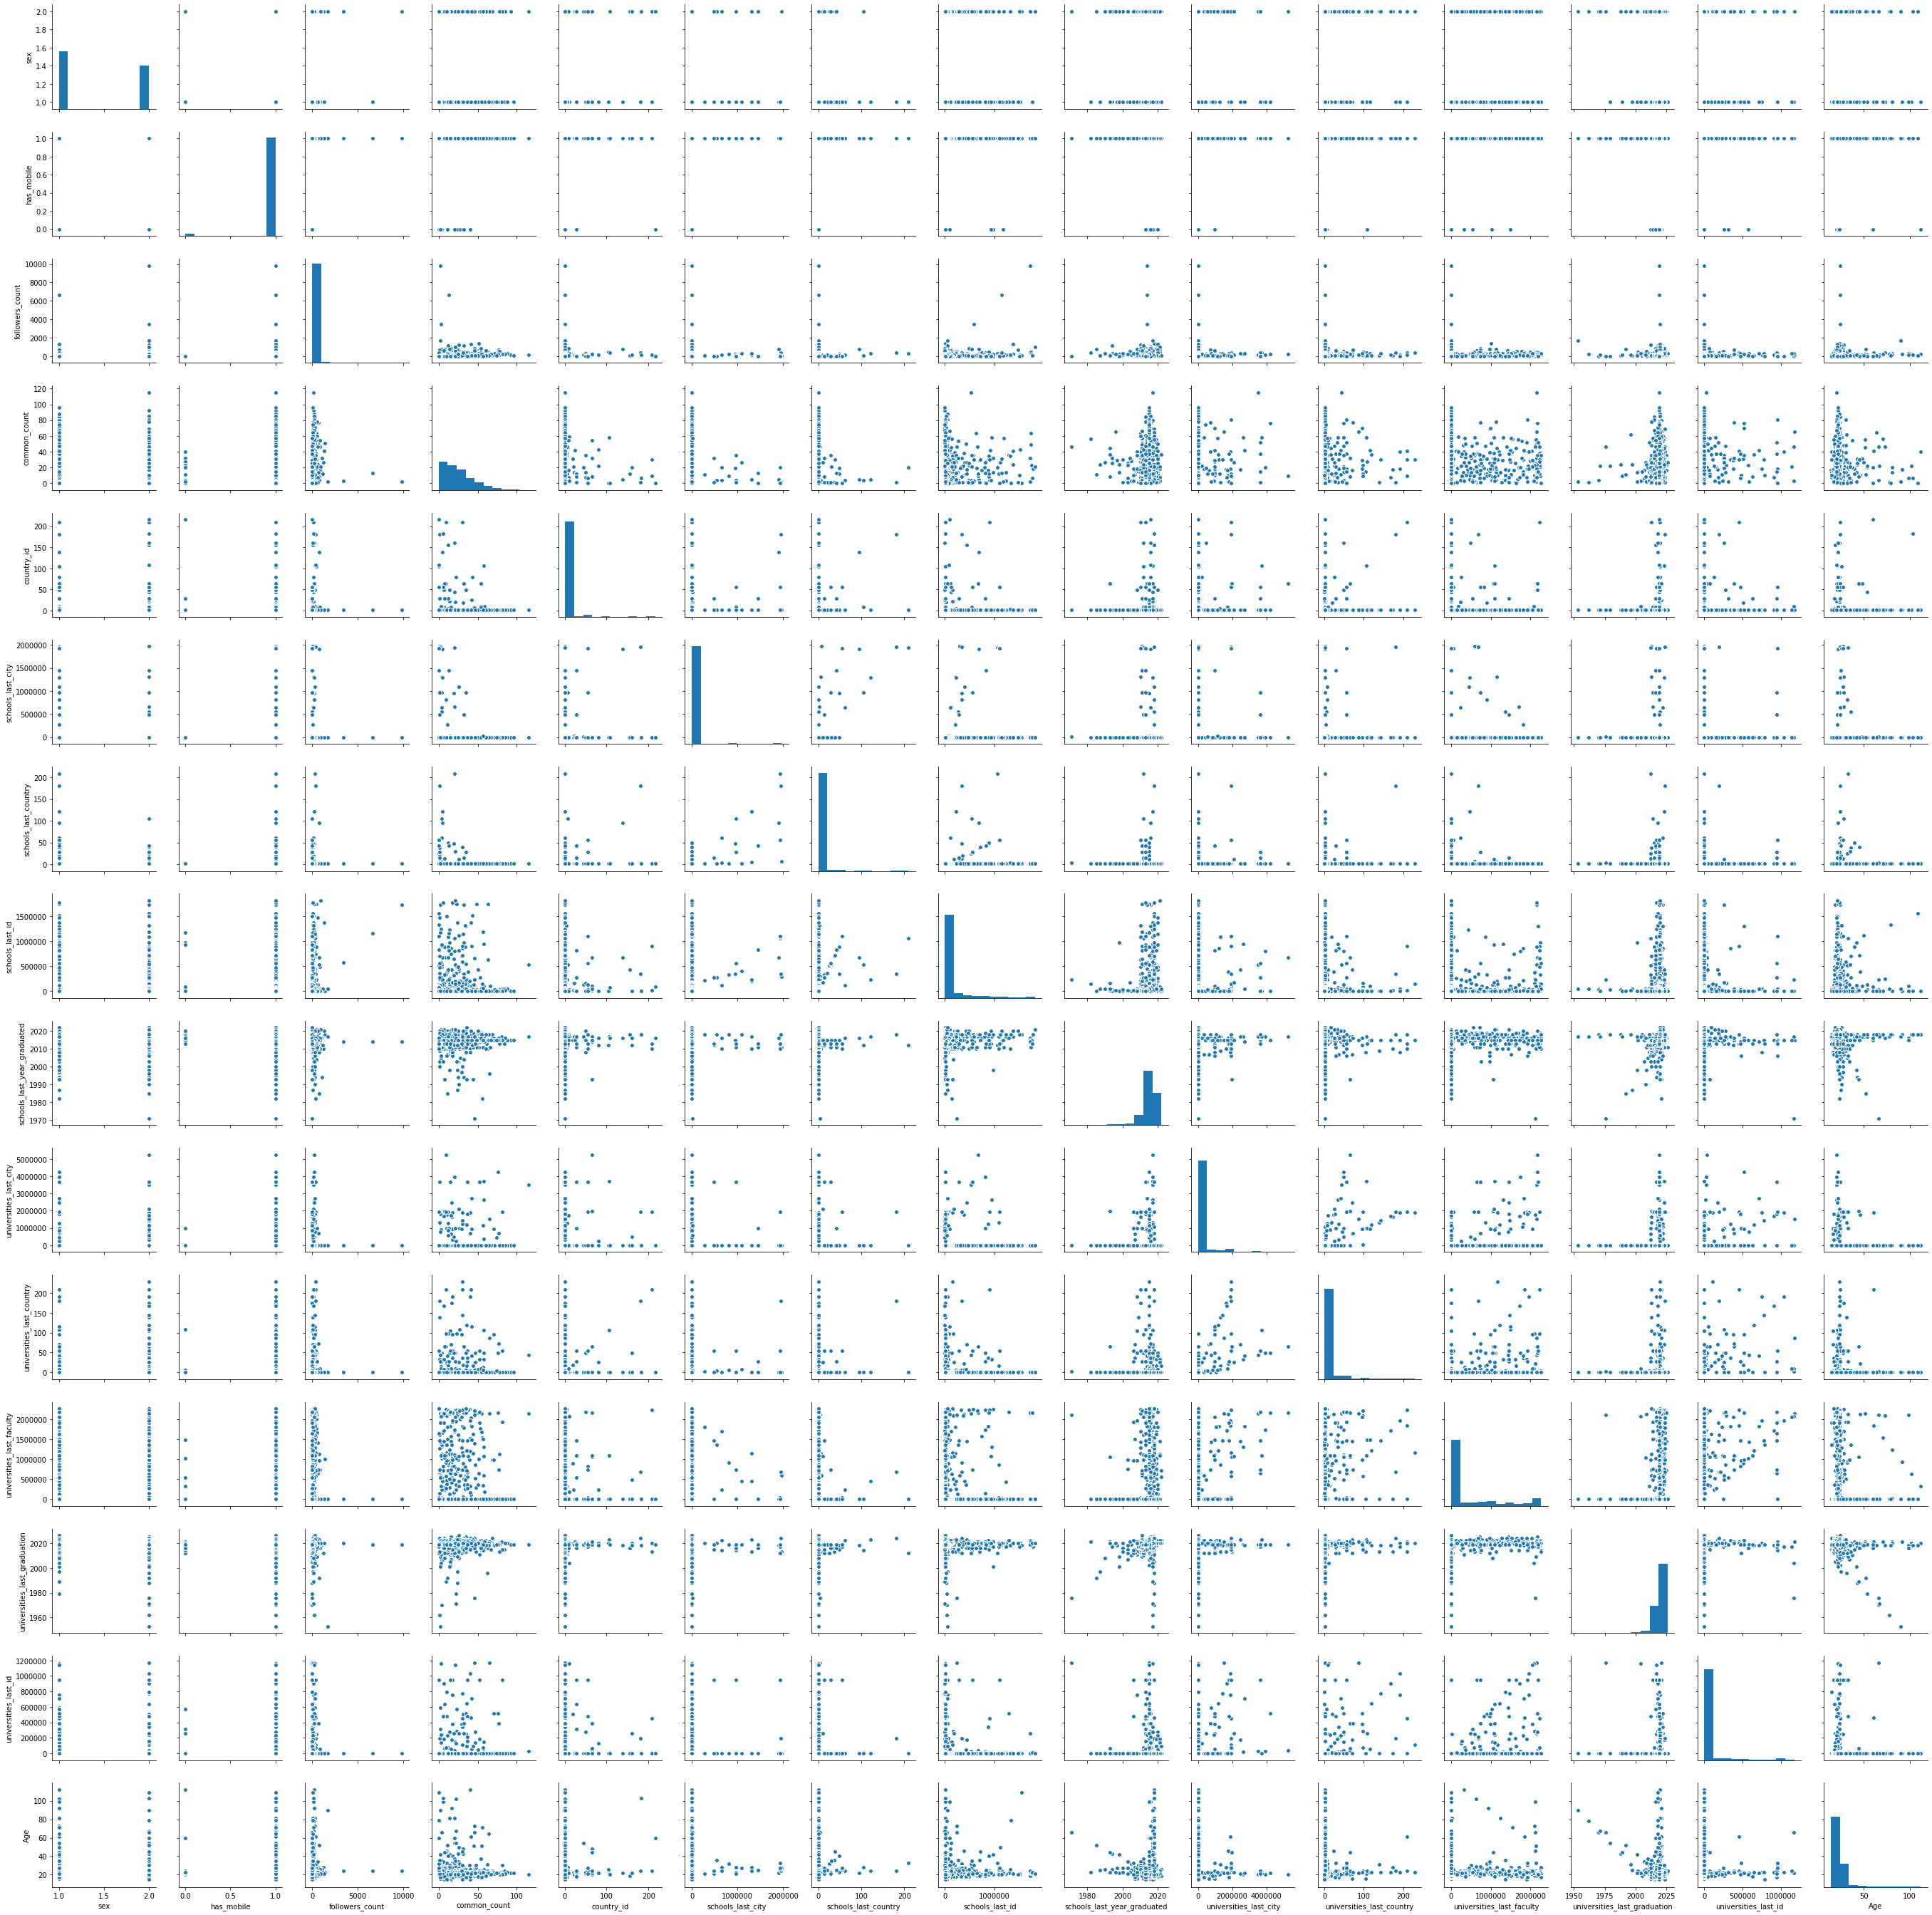

In [140]:
%%time
sns.pairplot(data)

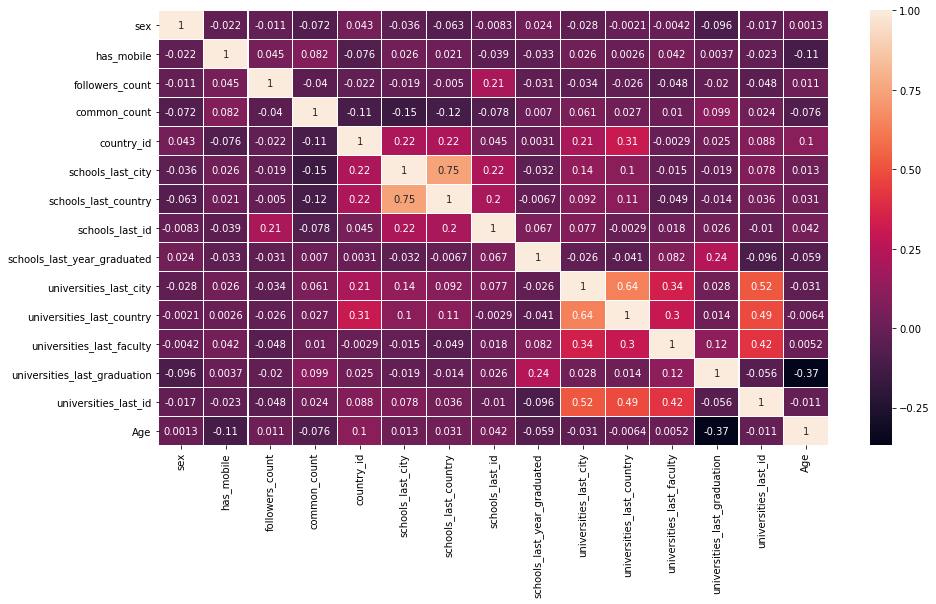

In [141]:
sns.heatmap(data.corr(),annot = True, linewidths = 0.2)
fig = plt.gcf()
fig.set_size_inches(15,8)

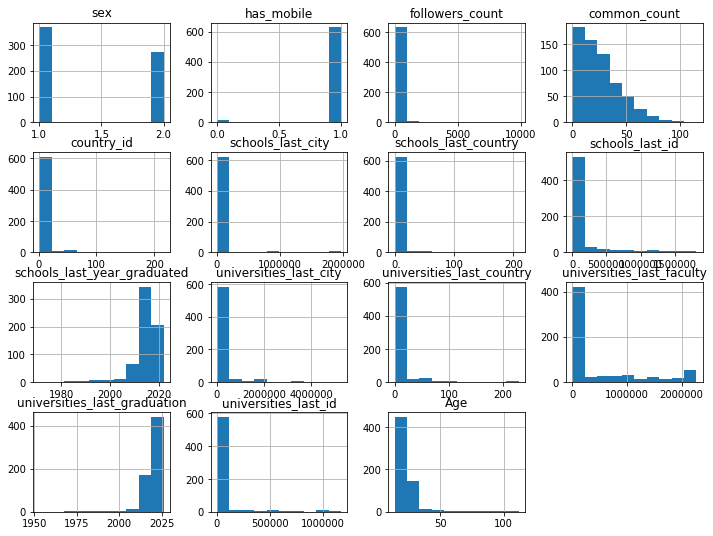

In [142]:
data.hist()
fig = plt.gcf()
fig.set_size_inches(12,9)

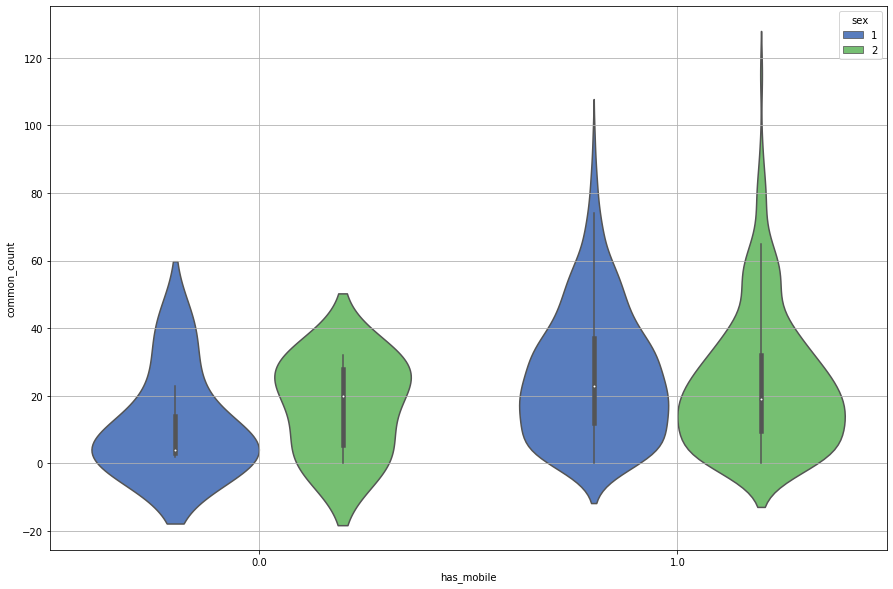

In [143]:
sns.violinplot(x="has_mobile", y="common_count", hue="sex",
                    data=data, palette="muted")
plt.grid()
fig = plt.gcf()
fig.set_size_inches(15,10)

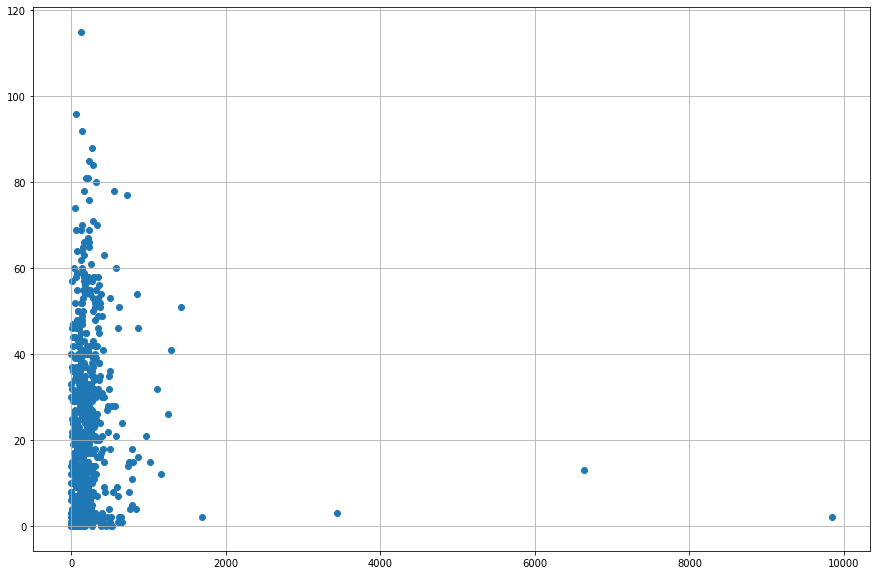

In [144]:
plt.scatter('followers_count','common_count',data = data)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(15,10)

In [145]:
data = clean_outlier_anomaly(df_func = data, whattoclean = 'anomaly', columns = ['Age'])
data = clean_outlier_anomaly(df_func = data, whattoclean = 'anomaly', columns = ['followers_count'])
data = clean_outlier_anomaly(df_func = data, whattoclean = 'anomaly', columns = ['common_count'])


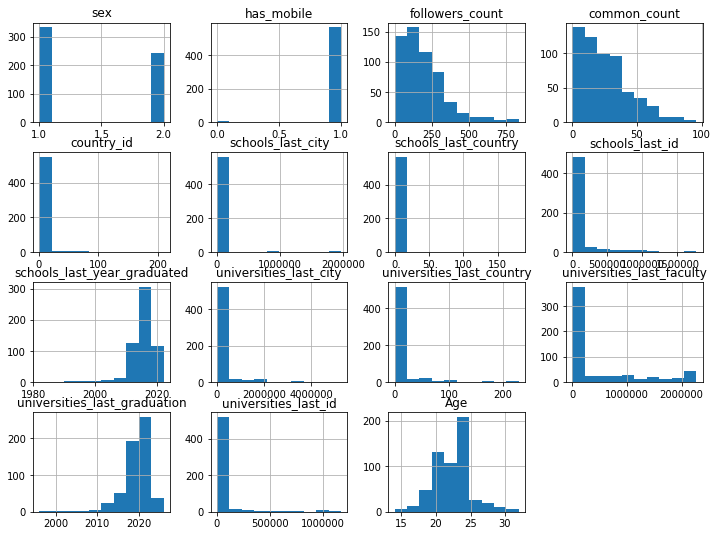

In [146]:
data.hist()
fig = plt.gcf()
fig.set_size_inches(12,9)

Text(0, 0.5, 'common_count')

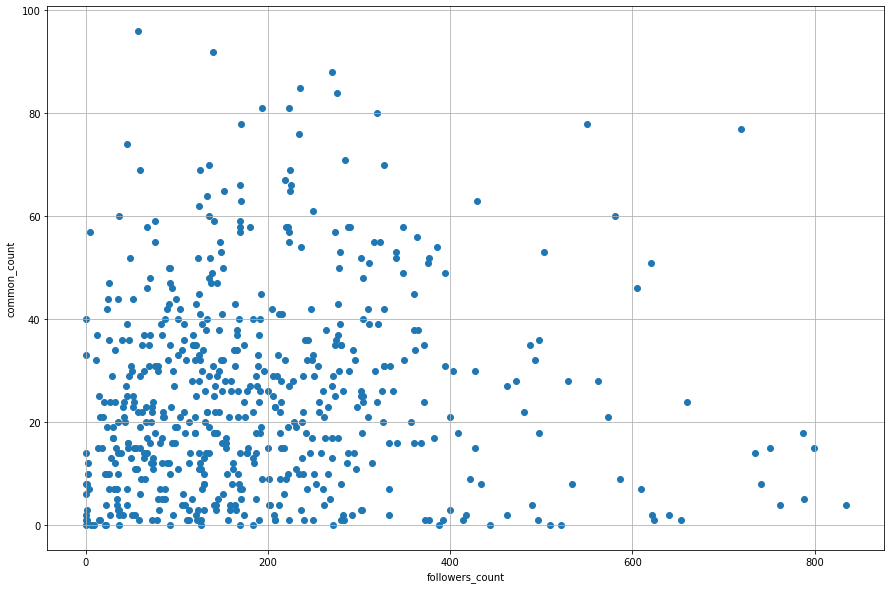

In [147]:
x = 'followers_count'
y = 'common_count'
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.scatter(x = x,y = y,data = data)
plt.grid()
plt.xlabel(x)
plt.ylabel(y)

In [148]:
data['home_town'] = data['home_town'].str.capitalize()

In [149]:
data['home_town'].unique()

array(['Москва', 'Комсомольск-на-амуре', 'Пермь', 'Самара, москва',
       'Moscow', 'Maskau', 'Нижневартовск', 'Волжский', 'Атомск',
       'Воронеж', 'Уфа', 'Россия', 'Тверь', 'Конченбург', 'Mосква',
       'Дзержинск', 'Старый оскол', 'Пекин', 'Волгоград-дубовка',
       'Иваново', 'Ковров', 'Берлин', 'Moscow-city', 'Пенза', 'Минск',
       'Санкт-петербург', 'Смоленск', 'Омск', 'Новый уренгой', 'Кимры',
       'Запрудня', 'Москва, сочи', 'New york', 'Город-герой москва',
       'Волгоград', 'Владимир', 'Домодедово', 'Москвабад', 'Новосибирск',
       'Moscow city', 'Париж', 'Гжатск ', 'Казань', 'Владикавказ',
       'Электросталь', 'Киров', 'Ярцево', 'Алматы', 'Якутск',
       'Иваново, москва', 'Memphis', 'Barcelona', 'Moscou', 'Самара',
       'Химки', 'Красноярск', 'Вологда', 'Шымкент', 'Буэнос-айрес',
       'Тула', 'Дыдылдино', 'Ноябрьск', 'Нижний новгород', 'Московушка',
       'Одинцово', 'Луховицы', 'Москва.', 'Никель, вологда', 'Элиста',
       'Đà  nẵng', 'Баку', 'Харьков

In [150]:
data['home_town'] = [x.split(',')[0] for x in data['home_town'].values ]
data['home_town'] = [x.split('.')[0] for x in data['home_town'].values ]

In [151]:
data['home_town'].unique()

array(['Москва', 'Комсомольск-на-амуре', 'Пермь', 'Самара', 'Moscow',
       'Maskau', 'Нижневартовск', 'Волжский', 'Атомск', 'Воронеж', 'Уфа',
       'Россия', 'Тверь', 'Конченбург', 'Mосква', 'Дзержинск',
       'Старый оскол', 'Пекин', 'Волгоград-дубовка', 'Иваново', 'Ковров',
       'Берлин', 'Moscow-city', 'Пенза', 'Минск', 'Санкт-петербург',
       'Смоленск', 'Омск', 'Новый уренгой', 'Кимры', 'Запрудня',
       'New york', 'Город-герой москва', 'Волгоград', 'Владимир',
       'Домодедово', 'Москвабад', 'Новосибирск', 'Moscow city', 'Париж',
       'Гжатск ', 'Казань', 'Владикавказ', 'Электросталь', 'Киров',
       'Ярцево', 'Алматы', 'Якутск', 'Memphis', 'Barcelona', 'Moscou',
       'Химки', 'Красноярск', 'Вологда', 'Шымкент', 'Буэнос-айрес',
       'Тула', 'Дыдылдино', 'Ноябрьск', 'Нижний новгород', 'Московушка',
       'Одинцово', 'Луховицы', 'Никель', 'Элиста', 'Đà  nẵng', 'Баку',
       'Харьков', 'Грозный', 'Губкинский', 'Липецк', 'Омутнинск',
       'Тарко-сале', 'Уездный

In [152]:
# Работаем с home_town
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder() 
encoder_df = pd.DataFrame(encoder.fit_transform(data[['home_town']]).toarray())
data = data.join(encoder_df)

In [153]:
data = data.drop(['home_town','schools_last_city','schools_last_country','universities_last_city',
                  'universities_last_country'],axis = 1)

In [154]:
data

,sex,has_mobile,followers_count,common_count,country_id,schools_last_id,schools_last_year_graduated,universities_last_faculty,universities_last_graduation,universities_last_id,...,69,70,71,72,73,74,75,76,77,78
0,2,1.0,60.0,15.0,1.0,58897.0,2008.0,941.0,2011.0,236.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1,1.0,123.0,3.0,1.0,2230.0,2006.0,29.0,2012.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,113.0,3.0,1.0,15547.0,2005.0,1390.0,2010.0,319.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1.0,215.0,28.0,1.0,2546.0,2011.0,33104.0,2012.0,328.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,1.0,51.0,2.0,1.0,290124.0,2011.0,591172.0,2013.0,305.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,1,1.0,14.0,15.0,1.0,4474.0,2013.0,2193434.0,2019.0,948666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504,2,1.0,2.0,1.0,28.0,279155.0,2013.0,1462299.0,2019.0,948666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
505,1,1.0,0.0,1.0,55.0,553836.0,2013.0,731164.0,2019.0,948666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
506,2,1.0,6.0,0.0,1.0,828518.0,2013.0,29.0,2019.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Разделение на train и test данные

In [155]:
X_train,X_test  = train_test_split(data, test_size = .20, random_state = 42)

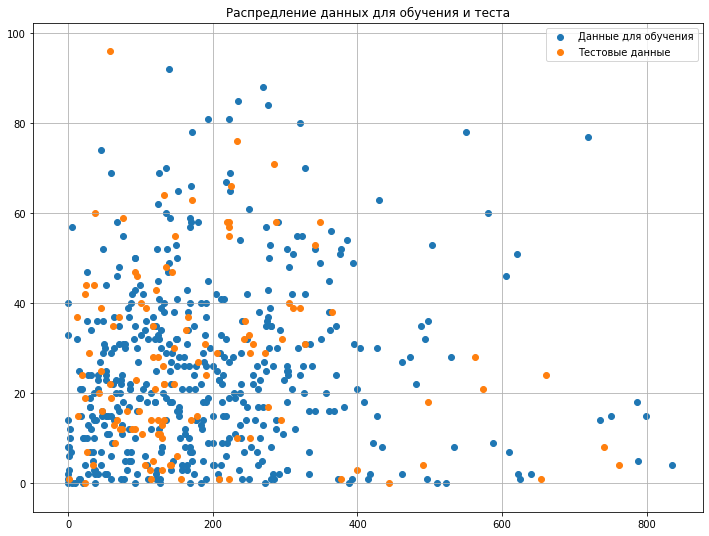

In [156]:
plt.scatter(X_train['followers_count'],X_train['common_count'], label = 'Данные для обучения')
plt.scatter(X_test['followers_count'],X_test['common_count'], label = 'Тестовые данные')

plt.legend()
plt.grid()

plt.title('Распредление данных для обучения и теста')

fig = plt.gcf()
fig.set_size_inches(12,9)

# Сравнение моделей

In [157]:
models = [KMeans(),MiniBatchKMeans(),MeanShift(),
          SpectralClustering(),AgglomerativeClustering()]
adjusted_rand_score
pipelines = []

for i in range(len(models)):
    pipelines.append(Pipeline([('scalar' + str(i+1),StandardScaler()),
                        ('pca' + str(i+1),PCA()),
                        (str(models[i]).split('(')[0],models[i])]))



In [158]:
sil_scores = []
dbs = [] 
inertia = []
fit_time = []
for pipe in pipelines:
        t1 = time.time()
        pipe.fit(X_train)
        t2 = time.time()
        
        print('----------------------------------------------------------')
        
        print('Модель кластеризации:', str(pipe[2]).split('(')[0])  
        print('Davies Bouldin score:', davies_bouldin_score(X_test,pipe[2].fit_predict(X_test)))
        print(f'Silhouette score : {silhouette_score(X_test,pipe[2].fit_predict(X_test))}')
        print(f'Fit time: {t2 - t1} sec.')
        sil_scores.append(silhouette_score(X_test,pipe[2].fit_predict(X_test)))
        dbs.append(davies_bouldin_score(X_test,pipe[2].fit_predict(X_test)))
        try:
            inertia.append(pipe[2].inertia_)
        except:
            inertia.append('-')
        fit_time.append(t2 - t1)
        
print('----------------------------')
# print('Вывод')
# print('Модель с лучшим silhouette score: ',str(pipelines[sil_scores.index(max(sil_scores))][2]).split('(')[0])
# print('И равен:', max(sil_scores)) 
# print('Модель с лучшим silhouette score: ',str(pipelines[dbs.index(min(dbs))][2]).split('(')[0])
# print('И равен:', min(dbs)) 

----------------------------------------------------------
Модель кластеризации: KMeans
Davies Bouldin score: 0.6312974630882248
Silhouette score : 0.6752265840444871
Fit time: 0.26543617248535156 sec.
----------------------------------------------------------
Модель кластеризации: MiniBatchKMeans
Davies Bouldin score: 0.5213345124272842
Silhouette score : 0.6732779364479324
Fit time: 0.09674263000488281 sec.
----------------------------------------------------------
Модель кластеризации: MeanShift
Davies Bouldin score: 0.5030004637834392
Silhouette score : 0.6636523492816755
Fit time: 1.9134759902954102 sec.
----------------------------------------------------------
Модель кластеризации: SpectralClustering
Davies Bouldin score: 16.386268246977227
Silhouette score : -0.4659022939093155
Fit time: 0.2902219295501709 sec.
----------------------------------------------------------
Модель кластеризации: AgglomerativeClustering
Davies Bouldin score: 0.5911028184847639
Silhouette score : 0.67

In [159]:
models_copy = models.copy()
models_copy = [str(model).split('(')[0] for model in models]
models_stats = pd.DataFrame({"Модель":models_copy,
                             "Fit time":fit_time,
                             'Silhouette score':sil_scores,
                             'Davies Bouldin score': dbs,
                            'Inertia':inertia})

In [160]:
models_stats

,Модель,Fit time,Silhouette score,Davies Bouldin score,Inertia
0,KMeans,0.265436,0.681270,0.630736,4.45073e+12
1,MiniBatchKMeans,0.096743,0.684915,0.612533,5.52531e+12
2,MeanShift,1.913476,0.663652,0.503000,-
3,SpectralClustering,0.290222,-0.531013,12.049301,-
4,AgglomerativeClustering,0.060839,0.679643,0.591103,-


# Улучшение модели

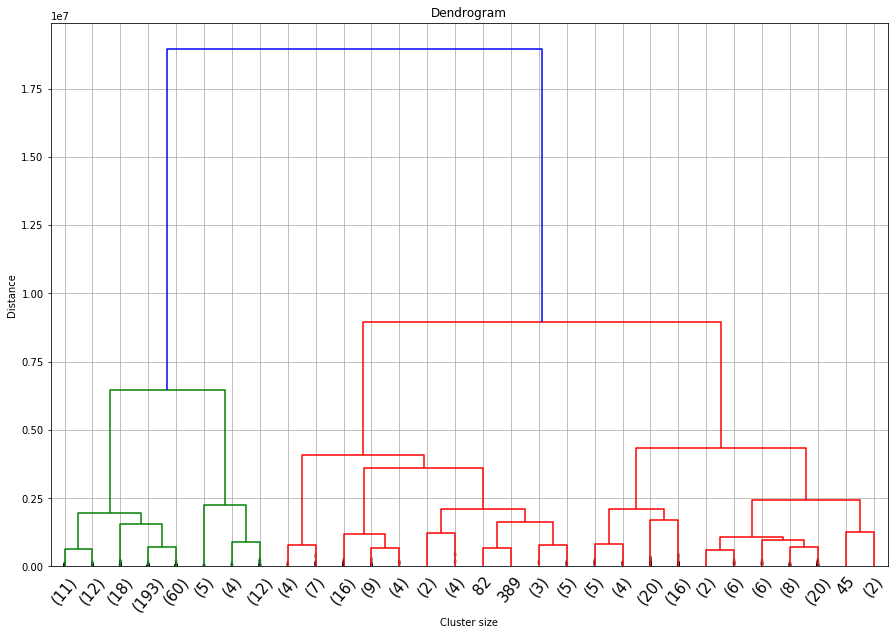

In [161]:
# Улучшение модели 
Z  = linkage(X_train,'ward')
dendrogram(Z, truncate_mode = 'lastp', leaf_rotation = 50. , leaf_font_size = 15., show_contracted = True)



plt.title('Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(15,10)




In [162]:
model = MiniBatchKMeans().fit(X_train)
clusters_test = model.predict(X_test)
X_test1 = X_test.copy()
X_test1['Cluster'] = clusters_test
#clusters_test
X_test1

,sex,has_mobile,followers_count,common_count,country_id,schools_last_id,schools_last_year_graduated,universities_last_faculty,universities_last_graduation,universities_last_id,...,70,71,72,73,74,75,76,77,78,Cluster
76,1,1.0,498.0,18.0,1.0,47513.0,2014.0,2162311.0,2019.0,259.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
247,2,1.0,163.0,34.0,3.0,1318309.0,2010.0,482.0,2018.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
427,2,1.0,130.0,10.0,1.0,2590.0,2018.0,479.0,2017.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
67,2,1.0,189.0,31.0,19.0,11111.0,2015.0,891775.0,2020.0,505275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
314,2,1.0,341.0,53.0,1.0,8813.0,2015.0,29.0,2020.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1,1.0,348.0,58.0,106.0,4293.0,2017.0,1097951.0,2023.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
53,1,1.0,741.0,8.0,1.0,2651.0,2012.0,477.0,2019.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
150,1,1.0,108.0,39.0,1.0,4110.0,2018.0,980021.0,2021.0,211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
154,2,1.0,365.0,38.0,1.0,4293.0,2017.0,2231306.0,2022.0,236.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Понижение размерности и выбор числа кластеров 

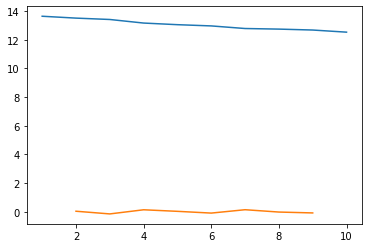

In [211]:
# Метод Локтя
from scipy.spatial.distance import pdist
X_test_tr = StandardScaler().fit(X_test).transform(X_test)
data_dist = pdist(X_test_tr, 'euclidean')
data_linkage = linkage(data_dist, method='average')
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()


In [164]:
X = X_train.append(X_test)
scaler = StandardScaler().fit(X)

X = scaler.transform(X)
X_embedded = TSNE(n_components=2, random_state = 22).fit_transform(X)
X_em_train = X_embedded[:len(X_train)]
X_em_test = X_embedded[-len(X_test):]

In [198]:
model = MiniBatchKMeans(n_clusters = 4,random_state = 30)
model.fit(X_em_train)
clusters = model.predict(X_em_test)

In [199]:
clusters

array([0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 3,
       0, 2, 1, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 2, 1,
       0, 0, 1, 0, 0, 2, 1, 1, 0, 2, 3, 0, 2, 0, 1, 1, 2, 0, 1, 2, 0, 0,
       1, 2, 2, 2, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 2, 1, 0, 2, 0, 0, 1, 1, 1, 1, 2, 1, 2, 0, 2, 2, 2, 2, 0, 2,
       0, 0, 1, 1, 2])

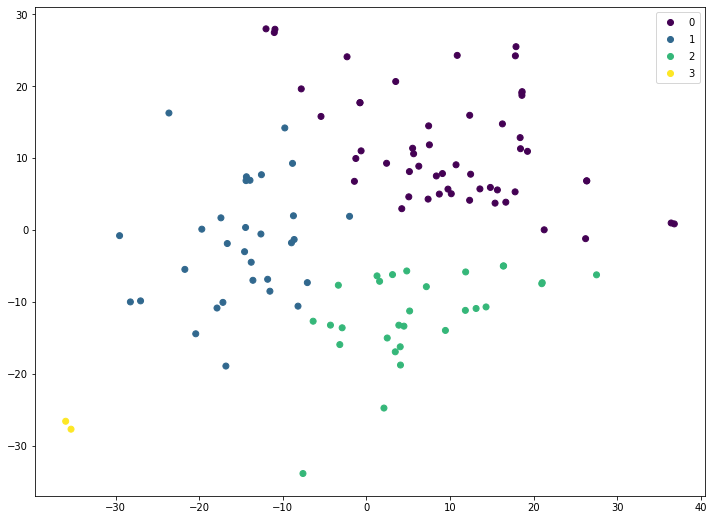

In [200]:
fig = plt.gcf()
fig.set_size_inches(12,9)
p = plt.scatter( x = [x[0] for x in X_em_test],y =[x[1] for x in X_em_test],  c = clusters, label = clusters)
a = p.legend_elements(prop = 'colors')
plt.legend(*a)


In [201]:
silhouette_score(X_em_test, model.fit_predict(X_em_test))

0.3543298

In [202]:
davies_bouldin_score(X_em_test, model.fit_predict(X_em_test))

0.8806534856113897

# Валидация

In [203]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 25)
for train_em_ind, test_em_ind in cv.split(X_embedded):
    X_em_train, X_em_test = X_embedded[train_em_ind], X_embedded[test_em_ind]
    model.fit(X_em_train)
    print('---------------------------------------------------------')
    print(silhouette_score(X_em_test, model.fit_predict(X_em_test)))
    print(davies_bouldin_score(X_em_test, model.fit_predict(X_em_test)))

---------------------------------------------------------
0.43569687
0.6419044736779129
---------------------------------------------------------
0.4090348
0.8113914080107523
---------------------------------------------------------
0.31376642
1.0560792349454315
---------------------------------------------------------
0.2711348
1.025524056690284
---------------------------------------------------------
0.3543298
0.8806534856113897


# Результаты

In [204]:
clusters = model.predict(X_embedded)

In [205]:
data['clusters'] = clusters

In [206]:
data

,sex,has_mobile,followers_count,common_count,country_id,schools_last_id,schools_last_year_graduated,universities_last_faculty,universities_last_graduation,universities_last_id,...,70,71,72,73,74,75,76,77,78,clusters
0,2,1.0,60.0,15.0,1.0,58897.0,2008.0,941.0,2011.0,236.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
0,1,1.0,123.0,3.0,1.0,2230.0,2006.0,29.0,2012.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,1.0,113.0,3.0,1.0,15547.0,2005.0,1390.0,2010.0,319.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1,1.0,215.0,28.0,1.0,2546.0,2011.0,33104.0,2012.0,328.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2,1.0,51.0,2.0,1.0,290124.0,2011.0,591172.0,2013.0,305.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,1,1.0,14.0,15.0,1.0,4474.0,2013.0,2193434.0,2019.0,948666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
504,2,1.0,2.0,1.0,28.0,279155.0,2013.0,1462299.0,2019.0,948666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
505,1,1.0,0.0,1.0,55.0,553836.0,2013.0,731164.0,2019.0,948666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
506,2,1.0,6.0,0.0,1.0,828518.0,2013.0,29.0,2019.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [216]:
t1 = time.time()
model.fit(X_embedded)
t2 = time.time()
clusters = model.predict(X_embedded)
print('Время обучения', round(t2 - t1,6), 'секунды')

Время обучения 0.046877 секунды


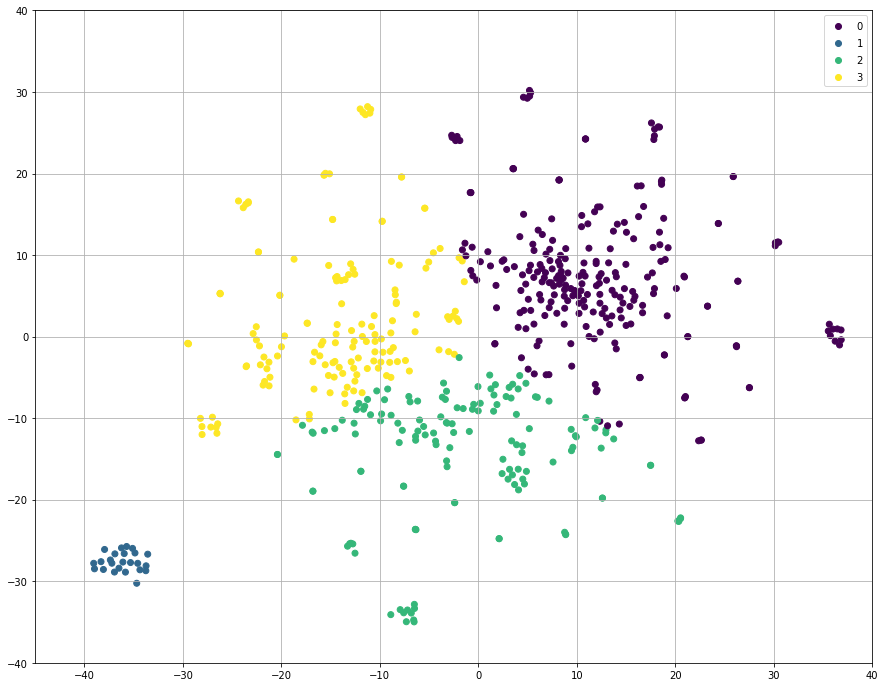

In [207]:
fig = plt.gcf()
fig.set_size_inches(15,12)
plt.scatter(x = [x[0] for x in X_embedded],y = [y[1] for y in X_embedded],c = clusters)
plt.grid()
plt.xlim(-45,40)
plt.ylim(-40,40)
a = p.legend_elements(prop = 'colors')
plt.legend(*a)


In [212]:
silhouette_score(X_embedded, model.fit_predict(X_embedded))

0.3912023

In [213]:
davies_bouldin_score(X_embedded, model.fit_predict(X_embedded))

0.875627780965932

In [209]:
data

,sex,has_mobile,followers_count,common_count,country_id,schools_last_id,schools_last_year_graduated,universities_last_faculty,universities_last_graduation,universities_last_id,...,70,71,72,73,74,75,76,77,78,clusters
0,2,1.0,60.0,15.0,1.0,58897.0,2008.0,941.0,2011.0,236.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
0,1,1.0,123.0,3.0,1.0,2230.0,2006.0,29.0,2012.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,1.0,113.0,3.0,1.0,15547.0,2005.0,1390.0,2010.0,319.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1,1.0,215.0,28.0,1.0,2546.0,2011.0,33104.0,2012.0,328.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2,1.0,51.0,2.0,1.0,290124.0,2011.0,591172.0,2013.0,305.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,1,1.0,14.0,15.0,1.0,4474.0,2013.0,2193434.0,2019.0,948666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
504,2,1.0,2.0,1.0,28.0,279155.0,2013.0,1462299.0,2019.0,948666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
505,1,1.0,0.0,1.0,55.0,553836.0,2013.0,731164.0,2019.0,948666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
506,2,1.0,6.0,0.0,1.0,828518.0,2013.0,29.0,2019.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [210]:
data.to_csv('results.csv')